# Generalised Least Squares
We will start our journey into the world of mixed-effects models by first examining a *related* approach that we have already seen before: Generalised Least Squares (GLS). The reason for doing this is twofold. Firstly, GLS actually provides a simpler solution to many of the issues with the repeated measures ANOVA and thus presents a more logical starting point. Secondly, limitations in the way that GLS does this will provide some motivation for mixed-effects as a more complex, but ultimately more flexible, method of dealing with this problem.

## GLS Theory
We previously came across GLS in the context of allowing different variances for different groups of data in ANOVA-type models. This was motivated as a way of limiting the assumption of *homogeneity of variance*. However, GLS is actually a much more general technique. To see this, we only need to recognise that the probability model for GLS is

$$
\mathbf{y} \sim \mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}\right),
$$

where $\boldsymbol{\Sigma}$ can take on *any structure*. In other words, GLS allows for a variety of different covariance structures, depending upon the data we have. In our previous examples, we used GLS to simply populate the variance-covariance matrix with different variances for each group. For instance, if we had two groups with three subjects each, our GLS model would be

$$
\begin{bmatrix}
y_{11} \\
y_{21} \\
y_{31} \\
y_{12} \\
y_{22} \\
y_{32} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
\mu_{1} \\
\mu_{1} \\
\mu_{1} \\
\mu_{2} \\
\mu_{2} \\
\mu_{2} \\
\end{bmatrix},
\begin{bmatrix}
\sigma^{2}_{1}  & 0              & 0              & 0              & 0              & 0              \\
0               & \sigma^{2}_{1} & 0              & 0              & 0              & 0              \\
0               & 0              & \sigma^{2}_{1} & 0              & 0              & 0              \\
0               & 0              & 0              & \sigma^{2}_{2} & 0              & 0              \\
0               & 0              & 0              & 0              & \sigma^{2}_{2} & 0              \\
0               & 0              & 0              & 0              & 0              & \sigma^{2}_{2} \\
\end{bmatrix}
\right).
$$

But, crucially, we can use GLS to impose a difference in *both* the variance structure (the *diagonal* elements of $\boldsymbol{\Sigma}$) *and* the covariance structure (the *off-diagonal* elements of $\boldsymbol{\Sigma}$). So while we did not do this previously, we can include *correlation* in the GLS model. Thus, if our general problem with repeated measures is that the variance-covariance structure is not correctly handled by the normal linear model, GLS provides a direct solution. Furthermore, if a core complaint of the repeated measures ANOVA is that the covariance structure that is assumed is too restrictive, GLS again provides a direct solution. So, on the face of it, GLS directly solves many of the issues we encountered last week.

### How Does GLS Work?
... So, the easiest way of understanding GLS is as a way of *correcting* the data by removing any correlation and removing any differences in variance to make the data suitable for OLS. This is an important perspective because to use GLS we have to 
    
1. Assume we know the covariance structure
2. Estimate this structure from the data and then remove it
3. Assume that OLS will then work fine

...At its most basic, GLS uses the residuals of an initial model fit to estimate the correlation/variance structure. This is then *removed* from the data. The corrected data is then, in theory, *uncorrelated* with *equal variance* and we can use OLS to estimate the parameters. This can all be achived effectively within a single estimation framework by using *restricted maximum likelihood* (REML). This will iteratively estimate the variance structure from the residuals and then estimate the parameters after removing the estimated variance structure. This continues until covergence (i.e. the parameters stop changing on each iteration). So we can think of GLS as a mechanism for *removing* a complex correlation or variance structure from the data, and then using a standard regression model on what remains.

### GLS in `R`
We already saw examples of using the `gls()` function from `nlme` last semester. However, we only focused on the use of the `weights=` argument with various variance structures (e.g. `varIdent()`, `var...()` etc.) However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of correlation and heterogenous variance groups. 

## The Paired $t$-test Using GLS

Where the notation `1|subject` indicates that we want a constant correlation (`1`) per-subject (`|subject`). So, the term on the *right* of the `|` is key here because this defines our *block-diagonal* structure. In effect, this term forms the *blocks*.

In [1]:
library(MASS)
library(nlme)
library(car)

set.seed(666)

var1  <- var2 <- 1
rho   <- 0.8
covar <- rho*sqrt(var1)*sqrt(var2)

Sigma <- matrix(data=c(var1,covar,covar,var2), nrow=2, ncol=2)
y     <- mvrnorm(n=50, mu=c(1,1.25), Sigma=Sigma)

subject <- rep(seq(from=1,to=50), each=2)
subject <- as.factor(subject)

y.long <- as.vector(t(y))    # Turn y into a column
cond   <- rep(c("A","B"),50) # Create a predictor for the two conditions
cond   <- as.factor(cond)

t.test(y[,1], y[,2], paired=TRUE, var.equal=TRUE)

gls.mod <- gls(y.long ~ cond, correlation=corCompSymm(form=~1|subject))
print(summary(gls.mod))

print(Anova(gls.mod))

#lme.mod <- lme(y.long ~ cond, random=(~1|subject))
#summary(lme.mod)


Loading required package: carData
Generalized least squares fit by REML
  Model: y.long ~ cond 
  Data: NULL 
       AIC      BIC    logLik
  248.5643 258.9042 -120.2822

Correlation Structure: Compound symmetry
 Formula: ~1 | subject 
 Parameter estimate(s):
      Rho 
0.8618049 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.9601951 0.15753402 6.095161  0.0000
condB       0.2066553 0.08282007 2.495232  0.0143

 Correlation: 
      (Intr)
condB -0.263

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.26305985 -0.76968978  0.01612246  0.63434195  2.17187084 

Residual standard error: 1.113934 
Degrees of freedom: 100 total; 98 residual
Analysis of Deviance Table (Type II tests)

Response: y.long
     Df  Chisq Pr(>Chisq)  
cond  1 6.2262    0.01259 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Inference Using GLS

Follow-up tests can also be performed using `emmeans`.

### The GLS Covariance Matrix

In [2]:
getVarCov(gls.mod)

Marginal variance covariance matrix
       [,1]   [,2]
[1,] 1.2408 1.0694
[2,] 1.0694 1.2408
  Standard Deviations: 1.1139 1.1139 

In [6]:
library(Matrix)

gls_marginal_cov <- function(fit) {
  n <- nobs(fit)

  # Correlation blocks (list) or single matrix if no grouping
  cs <- fit$modelStruct$corStruct
  if (is.null(cs)) {
    # No correlation structure: R = I
    Rlist <- list(Matrix::Diagonal(n))
    g <- factor(rep("all", n))
  } else {
    Rlist <- corMatrix(cs)
    g <- getGroups(fit)
    if (is.null(g)) g <- factor(rep("all", n))
  }

  # Variance weights (if no varStruct, all 1s)
  vs <- fit$modelStruct$varStruct
  w <- if (is.null(vs)) rep(1, n) else varWeights(vs)

  # Indices per group, aligned to the same order as used in the fit
  idx <- split(seq_along(g), g)

  sig2 <- fit$sigma^2

  # Build block covariance matrices: Sigma_g = sig2 * D^(1/2) R D^(1/2)
  # In nlme, varWeights are (typically) inverse-SD-type weights, so Var(e_i) = sig2 / w_i^2.
  Sig_blocks <- Map(function(R, ii) {
    Dhalf <- Matrix::Diagonal(x = 1 / w[ii])
    sig2 * (Dhalf %*% R %*% Dhalf)
  }, Rlist, idx)

  Matrix::bdiag(Sig_blocks)
}

We just print the first 8 rows to show the structure for the first 4 subjects.

In [7]:
Sigma <- gls_marginal_cov(gls.mod)
print(Sigma[1:8,1:8])

8 x 8 sparse Matrix of class "dgCMatrix"
                                                                            
[1,] 1.240848 1.069369 .        .        .        .        .        .       
[2,] 1.069369 1.240848 .        .        .        .        .        .       
[3,] .        .        1.240848 1.069369 .        .        .        .       
[4,] .        .        1.069369 1.240848 .        .        .        .       
[5,] .        .        .        .        1.240848 1.069369 .        .       
[6,] .        .        .        .        1.069369 1.240848 .        .       
[7,] .        .        .        .        .        .        1.240848 1.069369
[8,] .        .        .        .        .        .        1.069369 1.240848


A more general approach is to create an *image* of $\boldsymbol{\Sigma}$, either as a whole

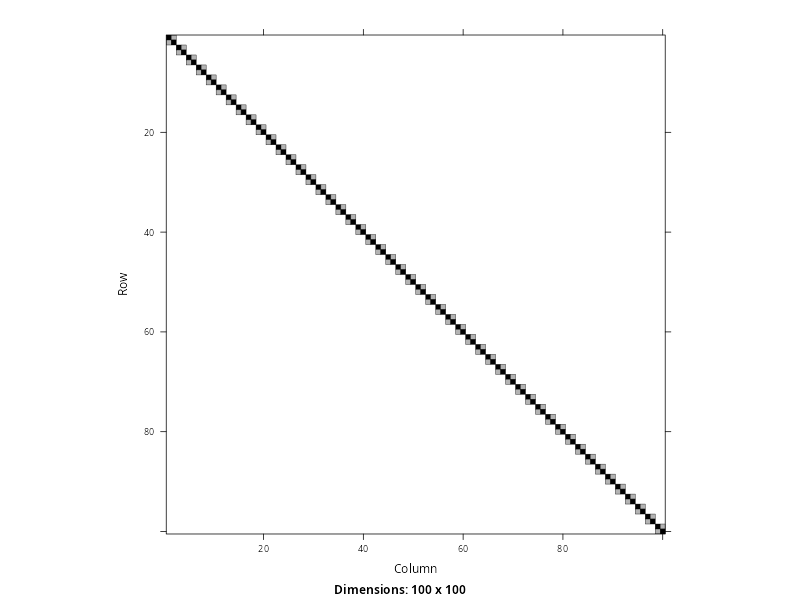

In [8]:
image(Sigma)

Or subsetted to show the general structure more clearly

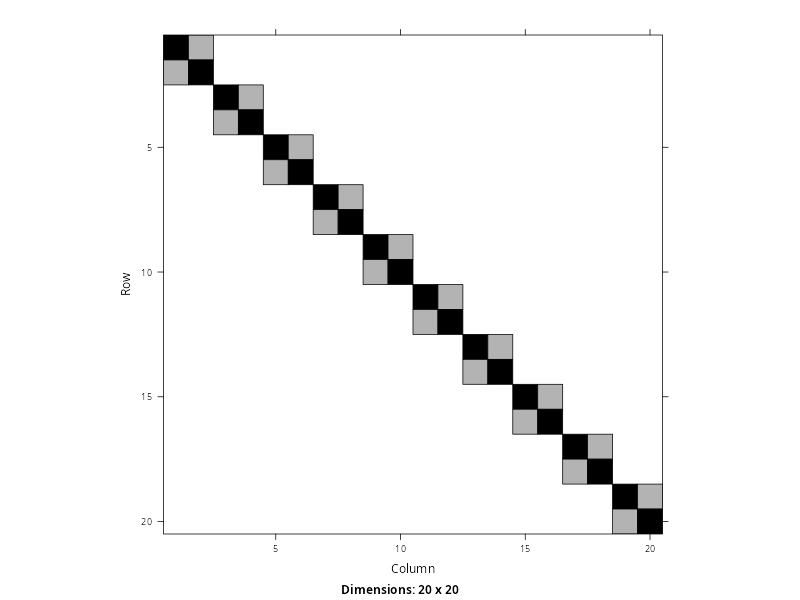

In [10]:
image(Sigma[1:20,1:20]) # first 10 subjects

These visualisations also help to make sense of the syntax used for defining the correlation structure. For instance, if we were to specify `form=~1|cond`, this would imply a constant correlation for each level of the repeated measures condition. What would this look like? Let us see

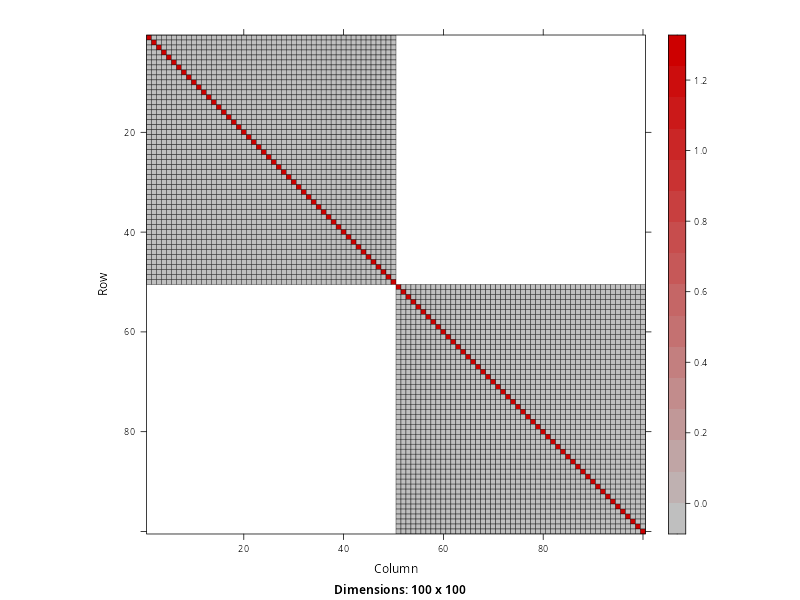

In [11]:
gls.mod <- gls(y.long ~ cond, correlation=corCompSymm(form=~1|cond))
image(gls_marginal_cov((gls.mod)))

The data are now organised by whatever term is on the *right* of `|`, so the first 50 rows represent all the data from condition 1 and the final 50 rows represents all the data from condition 2. So we can see that this structure implies that all the data from condition 1 are correlated across subjects, and all the data from condition 2 are correlated across subjects. This is not particularly sensible or meaningful, but hopefully it makes it clear how the syntax works.

Notice, however, that GLS is ignoring the structure in the data in terms of the subjects, because it has no knowledge of them.

## GLS for ANOVA Models
In the above example, we saw the use of GLS as an alternative to the paired $t$-test. A more usual application would be as an alternative to the Repeated Measures ANOVA as a means of side-stepping all the messy specification of different error terms for different tests.

### ANOVA Models with More Flexible Variance Structures
Perhaps the most useful elements of GLS is that we can use much more flexible variance structures than the simple compound-symmetric structure assumed by RM ANOVA. For instance, we can ask for a completely free within-subject correlations and a different variance for each between-subject group. For instance, specifying `corSymm(form=~1|subject)` and `varIdent(form=~1|group)` gives the most flexible structure that allows all correlations and variances to differ. However, we have to be careful because it is possible that there simply is not enough information in our data to allow this to be estimated, even if we want it.

## Why Not Stop at GLS?
... The problem is that GLS does not know anything about the *structure* of the data. It has no sense of *subjects* as the experimental unit, nor the idea that the outcome variable is comprised of clusters of values taken from different subjects who might themselves form clusters of values from larger groups (e.g. patients vs controls). All that GLS knows is that there is a correlation structure that we want to remove. Unfortunately, this lack of appreciation for the structure of the data means that GLS cannot use that structure to its advantage. There is no separation of the information available by pooling observations across subjects, or subjects across groups. In effect, GLS is a very *crude* solution to a bigger problem with repeated measurements. Namely, that there is a larger *hierarchical* structure at play that the model should be able to take advantage of. We have seen this in a very general way through small-sample degrees of freedom, but really this is only a *symptom* of a larger problem. As we will come to learn, mixed-effects models are advantageous precisely *because* they embed this structure in the model. This has a number of consequences, not least the fact that correlation between measurements from the same experimental unit are *automatically* embedded in the model. This is not because we tell the model to include correlation, rather it is a *natural consequence* of the structure of the data. As such, mixed-effects models are useful because features such as correlation are a natural part of the modelling framework, precisely because it does take the structure into account in a way that GLS simply cannot.

## When Can We Use GLS?
In reality, a GLS model is useful if you do not care about the hypothesis tests and just want estimates that accommodate a given correlation structure, or if you are using non-repeated measurement data and want a more flexible between-subjects variance structure. Alternatively, if you are taking many measurements from a *single* subject, GLS can be useful to model just their individual data. For instance, time-series data from one subject as measured using EEG, or eye-tracking, or continuous monitoring of hand movement. In these cases you can end up with thousands of data points and GLS can be used to model it using some suitable correlation structure (e.g. `corAR1(form=~time)`). The estimates could then be used as summary statistics to analyse multiple subjects[^summarystat-foot]. However, as we have seen above, GLS is not necessarily suitable for multiple subjects with repeated measurements because it does not accommodate the blocked structure of the data and thus fails to consider how this changes the number of independant pieces of information. This can be side-stepped by using asymptotic statistics that do not depend upon the concept of degrees of freedom. In large samples, this issue disappears, so if you have a large sample, or are willing to treat the $p$-values cautiously in small samples, GLS is a perfectly legitimate solution to the problem.

[^summarystat-foot]: This approach is, unsurprisingly, known as a *summary statistics* approach and is typical of how data analysis is handled for fMRI and M/EEG data.